### This project does not require Qutip

In [1]:
import numpy as np
from qutip import *
from qutip.qip.operations import rx
import scipy as sp
from scipy.optimize import curve_fit,fsolve
from scipy.special import erfc,erf
import os
import sys
import time
from copy import deepcopy
import matplotlib.pyplot as plt
import scipy.constants as sc

In [2]:
import scqubits as scq

In [ ]:
scq.GUI()

Container(children=[Sheet(children=[Card(children=[Img(layout=None, src='data:image/png;base64,iVBORw0KGgoAAAA…

### Readout Parameters

### When ground capcitances for JJA and phase slip junction are not the same

In [3]:
e_c=(sc.e)**2/2/sc.h/10**(-6)#e_c/C(fF)=f(in GHz). 1/10^(-6)=1/(fF*Giga)
print(e_c)
#we are using the units in which hbar=1 \implies h=2\pi. Therefore E=2\pi f.

19.37022932465912


In [4]:
#Catelani's data set 2 (these numbers are units of GHz*(2*\pi)=\omega)
N=43
EJ1=8.93
EJJ=26#JJA junction energy
Ec=24.2#coupling capacitance energy
Eg=194#ground capacitance energy
EC1=3.6# Phase-Slip junction energy
ECJ=1.24#JJA capacitance energy
Eg1=6#ground capciatnce for JJ
wr=8.18

In [5]:

#Emma's data set 1 (all values are omega, that is E in the units of (2\pi*GHz)=\omega). That is these are not energies but frequencies!
corr=1#2.62
tpi=1
N=int(122/corr)
EJ1=7.3*tpi# Phase-Slip junction energy. Modified from 7.3
EJJ=60/corr*tpi#JJA junction energy
Ec=e_c/1*tpi#coupling capacitance energy
Eg=e_c/corr/0.1*tpi#ground capacitance energy
ECJ=0.74*corr*tpi#JJA capacitance energy
Eg1=e_c/10*tpi#ground capacitance for JJ
E_tot=e_c/19.4*tpi#target capacitance (We can achieve this using the differential capacitance upto EJ/Ec=20)
wr=8.5*tpi#readout frequency
print(E_tot)
#check if target energy for C=C'+Cg1 is 1GHz
EC1=((1/E_tot-1/2/Eg1)**(-1))# Phase-Slip capacitance energy. Modified to have target capacitance equal to 2GHz, 1.2 because the ground capacitance is in parallel.
print(EC1)
print((1/EC1+2/Eg1)**(-1))
print(Eg1,Eg,Ec,EC1,ECJ)
"""

#Emma's data set 1 (all values are omega, that is E in the units of (2\pi*GHz)=\omega). That is these are not energies but frequencies!
tpi=1
N=122
EJ1=7.3*tpi# Phase-Slip junction energy. Modified from 7.3
EJJ=60*tpi#JJA junction energy
Ec=e_c/1*tpi#coupling capacitance energy
Eg=e_c/0.1*tpi#ground capacitance energy
ECJ=0.74*tpi#JJA capacitance energy
Eg1=e_c/10*tpi#ground capacitance for JJ
E_tot=e_c/19.4*tpi#target capacitance (We can achieve this using the differential capacitance upto EJ/Ec=20)
wr=8.5*tpi#readout frequency
print(E_tot)
#check if target energy for C=C'+Cg1 is 1GHz
EC1=((1/E_tot-1/2/Eg1)**(-1))# Phase-Slip capacitance energy. Modified to have target capacitance equal to 2GHz, 1.2 because the ground capacitance is in parallel.
print(EC1)
print((1/EC1+2/Eg1)**(-1))
print(Eg1,Eg,Ec,EC1,ECJ)


"""


0.9984654291061403
1.3451548142124392
0.5630880617633465
1.937022932465912 193.7022932465912 19.37022932465912 1.3451548142124392 0.74


"\n\n#Emma's data set 1 (all values are omega, that is E in the units of (2\\pi*GHz)=\\omega). That is these are not energies but frequencies!\ntpi=1\nN=122\nEJ1=7.3*tpi# Phase-Slip junction energy. Modified from 7.3\nEJJ=60*tpi#JJA junction energy\nEc=e_c/1*tpi#coupling capacitance energy\nEg=e_c/0.1*tpi#ground capacitance energy\nECJ=0.74*tpi#JJA capacitance energy\nEg1=e_c/10*tpi#ground capacitance for JJ\nE_tot=e_c/19.4*tpi#target capacitance (We can achieve this using the differential capacitance upto EJ/Ec=20)\nwr=8.5*tpi#readout frequency\nprint(E_tot)\n#check if target energy for C=C'+Cg1 is 1GHz\nEC1=((1/E_tot-1/2/Eg1)**(-1))# Phase-Slip capacitance energy. Modified to have target capacitance equal to 2GHz, 1.2 because the ground capacitance is in parallel.\nprint(EC1)\nprint((1/EC1+2/Eg1)**(-1))\nprint(Eg1,Eg,Ec,EC1,ECJ)\n\n\n"

### Common Parameters

In [6]:
kr=0.001#readout loss rate
Qr=wr/tpi/kr#Quality factor
print(Qr)
Z=200/np.pi#readout impedance \Ohms
Rk=25.8*10**(3)#resistance quantum. 25.8 K\Ohms
ECr=e_c/294*tpi#GHz capacitive energy of readout
ELr=137*tpi#GHz inductive energy of readout

8500.0


### E_t

In [7]:
#dominated by Eg1
Et1=((N-1)/Eg+2/Eg1+2/Ec)**(-1)
Et2=((N-1)/Eg+2/Eg1+1/Ec)**(-1)
Et3=((N-1)/Eg+1/Eg1+1/Ec)**(-1)
print(Et1,Et2,Et3)
print((N-1)/Eg,2/Eg1,2/Ec)

0.5680419156791531 0.5852033028597922 0.8385380660025593
0.6246699405151692 1.0325122983721806 0.10325122983721806


### Circuit Strengths

In [8]:
#Qubit charging energy (no change apart from Et from previous block)
G1=(1/64/Et1)*(1-(2/3)*(N**2-1)/N*(Et1/Eg))
G2=(1/64/Et2)*((1-Et2/Ec)**2)*(1-(2/3)*(N-1)/N)
G3=(1/64/Et3)*((1-Et3/Ec)**2)*(1-(2/3)*(N-2)/(N-1))
M1=1/16*(1/EC1+1/N/ECJ)
M2=1/16*(1/EC1+1/N/ECJ)
M3=1/16*(1/EC1+1/(N-1)/ECJ)
Charge1=1/16/(G1+M1)
Charge2=1/16/(G2+M2)
Charge3=1/16/(G3+M3)
print(Charge1)#in GHz
print(Charge2)#in GHz
print(Charge3)#in GHz
#We need N<<8*(np.pi**2)*Eg1/Charge1. 
#For large N we need to check for different approximation!
#print(Eg/Charge1)
#print(8*(np.pi**2))
print("Validity:",N/(8*(np.pi**2)*Eg/Charge1))

0.9177436958045079
1.12282923330709
1.1805792551745933
Validity: 0.007320769716792455


In [9]:
((EJJ/N/8/Charge1)**(1/4))/np.sqrt(2)

0.3597327749854321

### Only N degrees of freedom inspite of N+1 junctions due to flux quantization. All graphs for parasitic modes should be plotted for array elements between 1 and N-1, since I have reserved the zeroth mode to get the right indices for odd and even modes.

0.3032002286433497


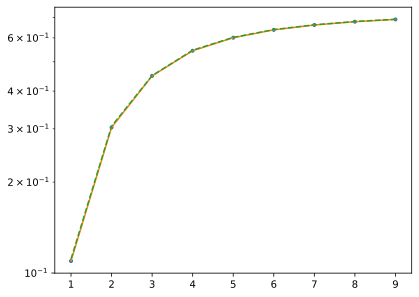

In [10]:
#Even-odd sector sector. These are omega=(2\pi) GHz and not frequency. [Charging energy for the even-odd sector]
E1=[0]
E2=[0]
E3=[0]
n=[0]
l1=(N-1)*Et1/Eg
l2=(N-1)*Et2/Eg
l3=(N-1)*Et3/Eg
def s(i,n):
    return np.sin(np.pi*i/2/n)
def c(i,n):
    return np.cos(np.pi*i/2/n)
def Ee(i,n):
    return (1/ECJ+1/(4*Eg*s(i,n)**2))**(-1)
def q(i,n):
    c1=0
    for k in range(1,n+1):
        if k!=i and np.mod(k,2)!=0:
            c1=c1+(c(k,n)**2*c(i,n)**2)/((n-1)**2*(n)**2*(s(i,n)**4*s(k,n)**2-s(i,n)**2*s(k,n)**4))
    return c1
def Eo(i,l,n):
    return (1/ECJ+1/(4*Eg*s(i,n)**2)-(l/2/Eg)*(c(i,n)**2)/(n-1)/(n)/s(i,n)**2+l**2/Eg*q(i,n))**(-1)    
for i in range(1,N):
    if np.mod(i,2)==0:
        E1.append(Ee(i,N))
        E2.append(Ee(i,N))
        E3.append(Ee(i,N-1))
    else:
        E1.append(Eo(i,l1,N))
        E2.append(Eo(i,l2,N))
        E3.append(Eo(i,l3,N-1))
    n.append(i)
plt.plot(n[1:10],E1[1:10],'.',label='H1')
plt.plot(n[1:10],E2[1:10],'-',label='H2')
plt.plot(n[1:10],E3[1:10],'--',label='H3')
plt.yscale('log')
plt.legend
print(E1[2])

### Remember that E starts with 0 whereas i starts with 1, so value of i=1 is stored in 0. functions will take values i while arrays will take values i-1


7.252289597492634
12.06383478620326
18.83775531522497


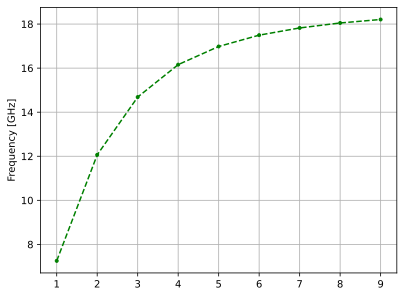

In [11]:
#Parasitic Mode Frequency in f (the E's are omegas as they are written in units of hbar!)
omega1=[0]
omega2=[0]
omega3=[0]
for i in range(1,N):
    omega1.append(np.sqrt(8*E1[i]*EJJ))
    omega2.append(np.sqrt(8*E2[i]*EJJ))
    omega3.append(np.sqrt(8*E3[i]*EJJ))
plt.plot(n[1:10],omega1[1:10],'.--',color='green',label='H1')
#plt.plot(n[1:10],omega2[1:10],'-',label='H2')
#plt.plot(n[1:10],omega3[1:10],'--',label='H3')
plt.ylabel('Frequency [GHz]')
#plt.ylabel(r'$\omega_\rho$ [GHz/$2\pi$]')

#plt.yscale('log')
print(omega1[1])
print(omega1[2])
print(omega1[-1])
plt.grid()
np.save("freq_Zhang.npy",omega1)

0.0009489526828094881
9.356439353609653e-06
1.4039468027682841e-08


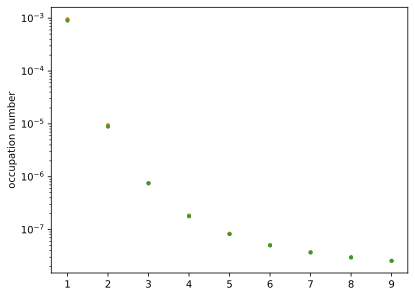

In [12]:
#occupation number of the parasitic modes
import scipy.constants as sc
T=50*10**(-3)
t=sc.h/T/sc.k/tpi
occ1=[0]
occ2=[0]
occ3=[0]
#Occupation number
for i in range(1,N):
    occ1.append(1/(np.exp(t*omega1[i]*10**9)-1))
    occ2.append(1/(np.exp(t*omega2[i]*10**9)-1))
    occ3.append(1/(np.exp(t*omega3[i]*10**9)-1))
plt.plot(n[1:10],occ1[1:10],'.',label='H1')
plt.plot(n[1:10],occ2[1:10],'.',label='H2')
plt.plot(n[1:10],occ3[1:10],'.',label='H3')
plt.yscale('log')
plt.ylabel('occupation number')
print(occ1[1])
print(occ1[2])
print(occ1[-1])

### Readout Coupling Strengths

In [13]:
#Qubit Coupling Strengths: Negative
g=0
g1=0
for i in range(1,N):
    if np.mod(i,2)!=0:
        g=g+Et2**2*E2[i]/8/Eg**2/Ec*(c(i,N)**2/2/N/s(i,N)**4)
for i in range(1,N-1):
    if np.mod(i,2)!=0:
        g1=g1+Et3**2*E3[i]/8/Eg**2/Ec*(c(i,N-1)**2/2/N/s(i,N-1)**4)

Cq1=(2*Charge1/Ec)#qubit coupling
Cq2=(2*Charge2/Ec*((N+1)*Et2/2/Eg+g))    
Cq3=(2*Charge3/Ec*(N*Et3/2/Eg+g1))

In [14]:
#Parasitic Mode Coupling Strengths (only even terms): Negative
r=2# is correct
Cp1=[0]
Cp2=[0]
Cp3=[0]
for i in range(1,N):
    if np.mod(i,2)==0:
        Cp1.append(2*r*Charge1*E1[i]*c(i,N)/4/np.sqrt(2*N)/Eg/Ec/s(i,N)**2)
        Cp2.append((2*r*Charge2*E2[i]*c(i,N)/4/np.sqrt(2*N)/Eg/Ec/s(i,N)**2)*(N+1)*Et1/2/Eg)
        Cp3.append((2*r*Charge3*E3[i]*c(i,N-1)/4/np.sqrt(2*(N-1))/Eg/Ec/s(i,N-1)**2)*N*Et1/2/Eg)
    else:
        Cp1.append(0)
        Cp2.append(0)
        Cp3.append(0)

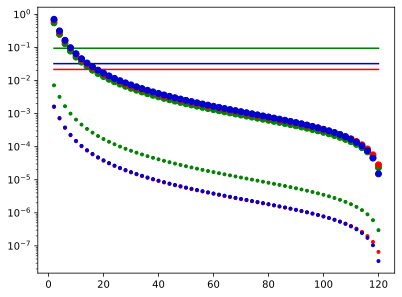

0.09475816526716918 0.007159099554016367 0.5546936004774475


<Figure size 640x480 with 0 Axes>

In [15]:
#Parasitic-Qubit Mode Coupling Strengths (only even terms)
pq1=[0]
pq2=[0]
pq3=[0]
for i in range(1,N):
    if np.mod(i,2)==0:
        pq1.append(r*np.sqrt(2/N)*Charge1*E1[i]*c(i,N)/Eg/s(i,N)**2)
        pq2.append(r*np.sqrt(2/N)*Charge2*E2[i]*c(i,N)/Eg/s(i,N)**2)
        pq3.append(r*np.sqrt(2/(N-1))*Charge3*E3[i]*c(i,N-1)/Eg/s(i,N-1)**2)
    else:
        pq1.append(0)
        pq2.append(0)
        pq3.append(0)
f=np.mod(N,2)
plt.plot(n[2::2],[Cq1]*(int(N/2)-1+f),'-',color='green',label='Qubit-Readout Coupling-H1')
plt.plot(n[2::2],[Cq2]*(int(N/2)-1+f),'-',color='red',label='Qubit-Readout Coupling-H2')
plt.plot(n[2::2],[Cq3]*(int(N/2)-1+f),'-',color='mediumblue',label='Qubit-Readout Coupling-H3')
plt.plot(n[2::2],Cp1[2::2],'.',color='green',label='Parasitic-Readout Coupling-H1')
plt.plot(n[2::2],Cp2[2::2],'.',color='red',label='Parasitic-Readout Coupling-H2')
plt.plot(n[2:-1:2],Cp3[2:-1:2],'.',color='mediumblue',label='Parasitic-Readout Coupling-H3')
plt.plot(n[2::2],pq1[2::2],'o',color='green',label='Qubit-Parasitic-H1')
plt.plot(n[2::2],pq2[2::2],'o',color='red',label='Qubit-Parasitic-H2')
plt.plot(n[2:-1:2],pq3[2:-1:2],'o',color='mediumblue',label='Qubit-Parasitic-H3')
plt.yscale('log')
#plt.xlim(0,N/2)
#plt.ylim(10**(-24),1)
#plt.legend()
plt.show()
plt.savefig('Coupling_Strength.pdf')
print(Cq1,Cp1[2],pq1[2])

### Coupling between qubit and readout (g)

In [16]:
zpf_p1=((EJJ/N/8/Charge1)**(1/4))/np.sqrt(2) #what are the zero point fluctuation values?
zpf_p2=((EJJ/N/8/Charge2)**(1/4))/np.sqrt(2) #what are the zero point fluctuation values?
zpf_p3=((EJJ/N/8/Charge3)**(1/4))/np.sqrt(2) #what are the zero point fluctuation values?
#under this assumption, zpf_p=1/zpf_x and x,p are defined as (a-a^\dagger)/sqrt(2)
print("Fluxonium Zero-point fluctuation of charge(n) operator for H_1:",zpf_p1)#Emma's is 0.35
print("Fluxonium Zero-point fluctuation of charge(n) operator for H_2:",zpf_p2)#Emma's is 0.35
print("Fluxonium Zero-point fluctuation of charge(n) operator for H_3:",zpf_p3)#Emma's is 0.35
zpf_pr=((ELr/8/ECr)**(1/4))/np.sqrt(2)
print(ECr)
print("Resonator Zero-point fluctuation of charge(n) operator:",zpf_pr)#Emma says this should be 2.84
VZPF=4*ECr*zpf_pr
#Since zero point fluctuations are untiless, Emma quoted the coefficient of the p_\phi p_r term and not n_\phi n_r
print("Coupling coefficient of p_\phi p_r in GHz for H_1:",Cq1*VZPF*zpf_p1)#Emma's calc says this is 0.026MHz
print("Coupling coefficient of p_\phi p_r in GHz for H_2:",Cq2*VZPF*zpf_p2)#Emma's calc says this is 0.026MHz
print("Coupling coefficient of p_\phi p_r in GHz for H_3:",Cq3*VZPF*zpf_p3)#Emma's calc says this is 0.026MHz
print(zpf_p1,zpf_p2,zpf_p3)
print(Cq1,Cq2,Cq3)#the total capacitance of the two circuits changed considerably
#If we are working with charge and not momentum then we should use Cq1*VZPF and not multiply zpf_p1

Fluxonium Zero-point fluctuation of charge(n) operator for H_1: 0.3597327749854321
Fluxonium Zero-point fluctuation of charge(n) operator for H_2: 0.3420439653117855
Fluxonium Zero-point fluctuation of charge(n) operator for H_3: 0.33778205492587327
0.06588513375734395
Resonator Zero-point fluctuation of charge(n) operator: 2.839198711323578
Coupling coefficient of p_\phi p_r in GHz for H_1: 0.025505853659556765
Coupling coefficient of p_\phi p_r in GHz for H_2: 0.005543296488338103
Coupling coefficient of p_\phi p_r in GHz for H_3: 0.008199163220159194
0.3597327749854321 0.3420439653117855 0.33778205492587327
0.09475816526716918 0.02165922749035697 0.03244066483616289


In [17]:
E=((e_c/294)*(e_c/19.4)/(e_c/294+e_c/19.4+e_c/1))*tpi#E_cr*E_\phi/(E_cr+E_\phi+E_c)
print(8*Charge1*ECr/Ec*zpf_pr)
print(8*E*2.84)

0.07090222363138766
0.07314136783384664


In [18]:
print(((EJJ/8/E1[2])**(1/4))/np.sqrt(2))

1.5769500487689814


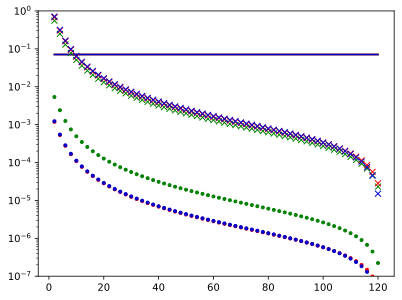

2.23032210363322


In [19]:
#Absolute parasitic-qubit coupling
zpf_pp1=[0]+[((EJJ/8/E1[i])**(1/4))/np.sqrt(2) for i in range(1,N)] #what are the zero point fluctuation values?
zpf_pp2=[0]+[((EJJ/8/E2[i])**(1/4))/np.sqrt(2) for i in range(1,N)] #what are the zero point fluctuation values?
zpf_pp3=[0]+[((EJJ/8/E3[i])**(1/4))/np.sqrt(2) for i in range(1,N)] #what are the zero point fluctuation values?
#zpf's are multiplied for parasitic mode and qubit mode but not the readout mode. So we only care about VZPF here

#coefficients to be used with the charge operators
gq1=np.array(Cq1)*VZPF
gq2=np.array(Cq1)*VZPF
gq3=np.array(Cq1)*VZPF

gp1=np.array(Cp1)*VZPF
gp2=np.array(Cp2)*VZPF
gp3=np.array(Cp3)*VZPF

gpq1=np.array(pq1)
gpq2=np.array(pq2)
gpq3=np.array(pq3)


#coupling strengths
g_q1=np.array(Cq1)*VZPF*zpf_p1
g_q2=np.array(Cq1)*VZPF*zpf_p2
g_q3=np.array(Cq1)*VZPF*zpf_p3

g_p1=np.array(Cp1)*VZPF*zpf_pp1
g_p2=np.array(Cp2)*VZPF*zpf_pp2
g_p3=np.array(Cp3)*VZPF*zpf_pp3

g_pq1=np.array(pq1)*zpf_p1*zpf_pp1
g_pq2=np.array(pq2)*zpf_p2*zpf_pp2
g_pq3=np.array(pq3)*zpf_p3*zpf_pp3

np.savez('Coupling_Strengths_H1.npz', coupling_p=g_p1, coupling_q=g_q1, coupling_pq=g_pq1)
np.savez('Coupling_Strengths_H2.npz', coupling_p=g_p2, coupling_q=g_q2, coupling_pq=g_pq2)
np.savez('Coupling_Strengths_H3.npz', coupling_p=g_p3, coupling_q=g_q3, coupling_pq=g_pq3)

plt.plot(n[2::2],[gq1]*(int(N/2)-1+f),'-',color='green',label='Qubit-Readout Coupling-H1')
plt.plot(n[2::2],[gq2]*(int(N/2)-1+f),'-',color='red',label='Qubit-Readout Coupling-H2')
plt.plot(n[2::2],[gq3]*(int(N/2)-1+f),'-',color='mediumblue',label='Qubit-Readout Coupling-H3')
plt.plot(n[2::2],gp1[2::2],'.',color='green',label='Parasitic-Readout Coupling-H1')
plt.plot(n[2::2],gp2[2::2],'.',color='red',label='Parasitic-Readout Coupling-H2')
plt.plot(n[2:-1:2],gp3[2:-1:2],'.',color='mediumblue',label='Parasitic-Readout Coupling-H3')
plt.plot(n[2::2],gpq1[2::2],'x',color='green',label='Qubit-Parasitic-H1')
plt.plot(n[2::2],gpq2[2::2],'x',color='red',label='Qubit-Parasitic-H2')
plt.plot(n[2:-1:2],gpq3[2:-1:2],'x',color='mediumblue',label='Qubit-Parasitic-H3')
plt.yscale('log')
#plt.xlim(0,N/2)
plt.ylim(10**(-7),1)
#plt.legend()
plt.savefig('Coupling_Strength.pdf')
plt.show()
print(gpq1[2]/gpq1[4])

In [20]:
print(0.92,0.5,12.06,0.0255,0.004,0.157)
print(Charge1, EJJ/N,omega1[2],g_q1,g_p1[2],g_pq1[2])
print(Charge1, EJJ/N,omega1[2],gq1,gp1[2],gpq1[2])
print(zpf_p1,zpf_pp1[2])
#Charge1=0.9177436958045079
#gq1=0.07090222363138766
#gp1[2]=0.0026783764551955858
#gpq1[2]=0.27734680023872377

0.92 0.5 12.06 0.0255 0.004 0.157
0.9177436958045079 0.4918032786885246 12.06383478620326 0.025505853659556765 0.008447331763284742 0.3146669279564588
0.9177436958045079 0.4918032786885246 12.06383478620326 0.07090222363138766 0.0053567529103911715 0.5546936004774475
0.3597327749854321 1.5769500487689814


### Charge Martix Elements (Numerical Diagonalization)

-5.026084949384103
-2.929292929292929


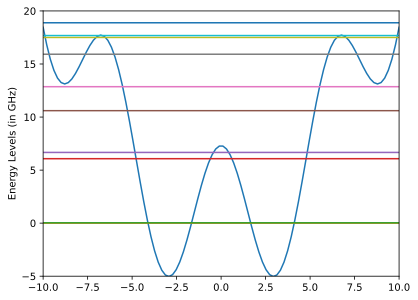

In [30]:
x=np.linspace(-10,10,100)
import math as ma
def y(x,a,b):
    return (a*np.cos(x)+(b/2)*x**2)
def y1(x,a,b):#upto 20 terms we can determine the behaviour of the well here!
    N=21
    c=(b/2)*x**2
    for i in range(0,N,2):
        c=c+(-1)**(i/2)*a/ma.factorial(i)*(x**i)
    return c

def y2(x,a,b,a1,b1):
    N=3
    c=0
    if np.abs(x)<np.abs(np.abs(x)-3):
        c=(b1/2)*x**2
        for i in range(0,N,2):
            c=c+(-1)**(i/2)*a1/ma.factorial(i)*(x**i)
    else:    
        for i in range(0,N,2):
            if np.abs(x-b)<np.abs(x+b):
                c=c+(-1)**(i/2)*a/ma.factorial(i)*((x-b)**i)
            else:
                c=c+(-1)**(i/2)*a/ma.factorial(i)*((x+b)**i)
    return c
y=[y(i,EJ1,EJJ/N) for i in x]#fluxonium at half flux because cosine has the same sign as x^2!
y1=[y1(i,EJ1,EJJ/N) for i in x]#fluxonium at half flux because cosine has the same sign as x^2!
print(min(y))
y2=[y2(i,min(y),x[np.argmin(y)],EJ1,EJJ/N) for i in x]#fluxonium at half flux because cosine has the same sign as x^2!
plt.plot(x,y)
#plt.plot(x,y1)
#plt.plot(x,y2)
plt.ylim(-5,20)
plt.xlim(-10,10)
for i in range(10):
    plt.plot(x,[flux_e1[i]-flux_e1[0]]*100)
plt.ylabel('Energy Levels (in GHz)')
print(x[np.argmin(y)])

In [31]:
np.save("energy.npy",flux_e1)

In [32]:
# Fluxonium Hamiltonian
# There is something weird here. The zero-point fluctuations should have the units of energy! 
# We know that the zero-point fluctuations of n is constant
# For zero-point fluctuations in flux, this should also be a constant! 
Ncav=100
a=destroy(Ncav)
ad=a.dag()
EL=EJJ/N
zpf_x=(((8*Charge1)/(EJJ/N))**(1/4))/np.sqrt(2) #what are the zero point fluctuation values?
zpf_p=1/(2*zpf_x) #what are the zero point fluctuation values?
nOp1=-1j*(a-ad)*zpf_p
fOp1=(a+ad)*zpf_x
cosfOp1=((1j*fOp1).expm()+(-1j*fOp1).expm())/2
H1=4*(Charge1)*(nOp1**2)+(EJ1)*cosfOp1+0.5*(EL)*fOp1**2# in GHz not omega
print("Emma's Zero-point fluctuation of phase operator:",1.4)
print("My Zero-point fluctuation of phase operator for H_1:",zpf_x)
print("My Zero-point fluctuation of charge operator for H_1:",1/2/zpf_x)
#Now keep only 20 levels in this basis to define the new charge operator and the flux operator!
#H1_trun=[flux_e1[i]*ket2dm(Qobj(flux_s1[i])) for i in range(20)]

Emma's Zero-point fluctuation of phase operator: 1.4
My Zero-point fluctuation of phase operator for H_1: 1.3899206154352994
My Zero-point fluctuation of charge operator for H_1: 0.3597327749854322


In [33]:
#Fluxonium Hamiltonian
zpf_x2=(((8*Charge2)/(EJJ/N))**(1/4))/np.sqrt(2) #what are the zero point fluctuation values?
zpf_p2=1/2/zpf_x2#what are the zero point fluctuation values?
pOp2=-1j*(a-ad)
xOp2=(a+ad)
nOp2=-pOp2*zpf_p2
fOp2=xOp2*zpf_x2
cosfOp2=((1j*fOp2).expm()+(-1j*fOp2).expm())/2
H2=4*(Charge2)*nOp2**2+(EJ1)*cosfOp2+0.5*(EJJ/N)*fOp2**2
print("My Zero-point fluctuation of phase operator for H_2:",zpf_x2)

My Zero-point fluctuation of phase operator for H_2: 1.4618003844746443


In [34]:
#Fluxonium Hamiltonian
zpf_x3=(((8*Charge3)/(EJJ/(N-1)))**(1/4))/np.sqrt(2) #what are the zero point fluctuation values?
zpf_p3=1/2/zpf_x3#what are the zero point fluctuation values?
pOp3=-1j*(a-ad)
xOp3=(a+ad)
nOp3=-pOp3*zpf_p3
fOp3=xOp3*zpf_x3
cosfOp3=((1j*fOp3).expm()+(-1j*fOp3).expm())/2
H3=4*(Charge3)*nOp3**2+(EJ1)*cosfOp3+0.5*(EJJ/(N-1))*fOp3**2
print("My Zero-point fluctuation of phase operator for H_3:",zpf_x3)

My Zero-point fluctuation of phase operator for H_3: 1.477201757940573


In [35]:
flux_e1,flux_s1=H1.eigenstates()
flux_e2,flux_s2=H2.eigenstates()
flux_e3,flux_s3=H3.eigenstates()

In [70]:
print((flux_e1[13]-flux_e1[0]+omega1[2])/9.45)

4.026792434250423


In [36]:
print(r'$\omega_{10}$:',flux_e1[1]-flux_e1[0])#Emma's value=0.0337 GHz
print(r'$\omega_{10}$:',flux_e2[1]-flux_e2[0])#Emma's value=0.0337 GHz
print(r'$\omega_{10}$:',flux_e2[1]-flux_e2[0])#Emma's value=0.0337 GHz
print(r'$\omega_{12}$:',flux_e1[2]-flux_e1[1])#Emma's value=6.082 GHz
print(r'$\omega_{12}$:',flux_e2[2]-flux_e2[1])#Emma's value=6.082 GHz
print(r'$\omega_{12}$:',flux_e3[2]-flux_e3[1])#Emma's value=6.082 GHz

$\omega_{10}$: 0.030182686182229412
$\omega_{10}$: 0.06060554864541734
$\omega_{10}$: 0.06060554864541734
$\omega_{12}$: 6.044558715857117
$\omega_{12}$: 6.3709214594813455
$\omega_{12}$: 6.445811234707945


In [37]:
#We replace this by Charge1 and we get a completely different number!
import scqubits as scq
from scqubits import Fluxonium
#This Hamiltonian takes information related to zero-point fluctuations when we compute charge elements
fluxonium = scq.Fluxonium(EJ = EJ1,
                               EC = Charge1,#EC1
                               EL = EJJ/N,
                               flux = 0.5,
                               cutoff = 100)
H=Qobj(fluxonium.hamiltonian())
sc_n=Qobj(fluxonium.n_operator())#this n operator has the zpf included
flux_e,flux_s=H.eigenstates()
print(flux_e[1]-flux_e[0])
print(flux_e[2]-flux_e[1])
print(Charge1, EJJ/N,EJ1)

0.030182686182325336
6.044558715857019
0.9177436958045079 0.4918032786885246 7.3


Text(0.5, 0, 'qubit-eigenmodes')

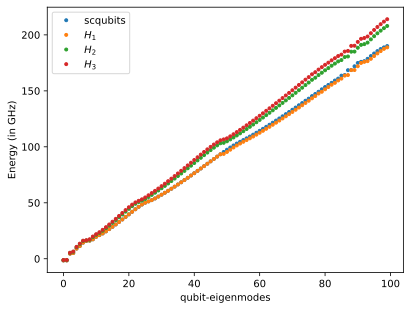

In [38]:
#energies are in GHz not omega
#We have confirmed that energies for H1, H2, H3 agree with scqubits
plt.plot(flux_e,'.',label='scqubits')
plt.plot(flux_e1,'.',label=r'$H_1$')
plt.plot(flux_e2,'.',label=r'$H_2$')
plt.plot(flux_e3,'.',label=r'$H_3$')
plt.legend()
plt.ylabel('Energy (in GHz)')
plt.xlabel('qubit-eigenmodes')

for the first few modes our result is the same as scqubits
0.011816767692680434


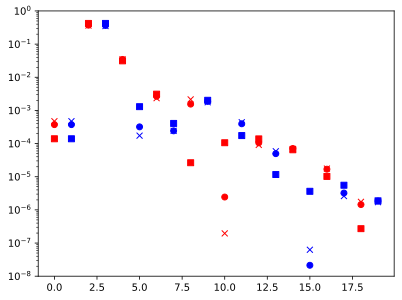

In [44]:
#charge matrix elements mod squared [There is a factor of 2 to be checked here]
def charge_mat(m,n):
    return np.abs(((Qobj(flux_s[n]).dag())*sc_n*Qobj(flux_s[m])))**2
def charge_mat1(m,n):
    return np.abs(((Qobj(flux_s1[n]).dag())*nOp1*Qobj(flux_s1[m])))**2
def charge_mat2(m,n):
    return np.abs(((Qobj(flux_s2[n]).dag())*nOp2*Qobj(flux_s2[m])))**2
def charge_mat3(m,n):
    return np.abs(((Qobj(flux_s3[n]).dag())*nOp3*Qobj(flux_s3[m])))**2
p0=[charge_mat(0,l) for l in range(Ncav)]
p1=[charge_mat(1,l) for l in range(Ncav)]
p10=[charge_mat1(0,l) for l in range(Ncav)]
p11=[charge_mat1(1,l) for l in range(Ncav)]
p20=[charge_mat2(0,l) for l in range(Ncav)]
p21=[charge_mat2(1,l) for l in range(Ncav)]
p30=[charge_mat3(0,l) for l in range(Ncav)]
p31=[charge_mat3(1,l) for l in range(Ncav)]
#plt.plot(p0,'x',color='blue',label=r'$H_1:|\langle 0|n_\phi|l\rangle|^2$')
#plt.plot(p1,'x',color='red',label=r'$H_1:|\langle 1|n_\phi|l\rangle|^2$')
plt.plot(p10[:20],'s',color='blue',label=r'$H_1:|\langle 0|n_\phi|l\rangle|^2$')
plt.plot(p11[:20],'s',color='red',label=r'$H_1:|\langle 1|n_\phi|l\rangle|^2$')
plt.plot(p20[:20],'o',color='blue',label=r'$H_2:|\langle 0|n_\phi|l\rangle|^2$')
plt.plot(p21[:20],'o',color='red',label=r'$H_2:|\langle 1|n_\phi|l\rangle|^2$')
plt.plot(p30[:20],'x',color='blue',label=r'$H_3:|\langle 0|n_\phi|l\rangle|^2$')
plt.plot(p31[:20],'x',color='red',label=r'$H_3:|\langle 1|n_\phi|l\rangle|^2$')
plt.yscale('log')
plt.ylim(10**(-8),1)
#plt.legend()
print('for the first few modes our result is the same as scqubits')
print(np.sqrt(charge_mat(0,1)))

for the first few modes our result is the same as scqubits
0.011816767692680434


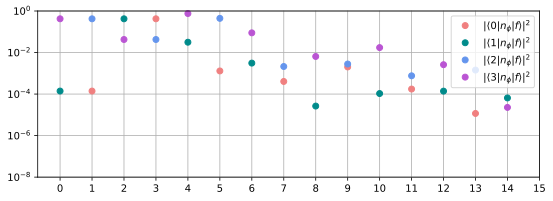

In [45]:
fig,ax=plt.subplots(1,1,figsize=(9,3))
p0=[charge_mat1(0,l) for l in range(Ncav)]
p1=[charge_mat1(1,l) for l in range(Ncav)]
p2=[charge_mat1(2,l) for l in range(Ncav)]
p3=[charge_mat1(3,l) for l in range(Ncav)]
np.savez('Charge_Matrix.npz', p0=p0, p1=p1, p2=p2)
plt.plot(p0[:15],'o',color='lightcoral',label=r'$|\langle 0|n_\phi|f\rangle|^2$')
plt.plot(p1[:15],'o',color='darkcyan',label=r'$|\langle 1|n_\phi|f\rangle|^2$')
plt.plot(p2[:15],'o',color='cornflowerblue',label=r'$|\langle 2|n_\phi|f\rangle|^2$')
plt.plot(p3[:15],'o',color='mediumorchid',label=r'$|\langle 3|n_\phi|f\rangle|^2$')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.xticks(np.linspace(0,15,16))
plt.ylim(10**(-8),1)
#plt.legend()
print('for the first few modes our result is the same as scqubits')
print(np.sqrt(charge_mat(0,1)))
plt.savefig("Charge.pdf")

In [46]:
def k1(rho):#everything GHz, valid only for even rho!
    return ((VZPF**2)/4)*(np.sqrt(EJJ/8/E1[rho]))*Cp1[rho]**2/(omega1[rho]-wr)
freq1=[0]
for i in range(1,N):
    freq1.append(k1(i))

In [47]:
def k2(rho):#everything GHz, valid only for even rho!
    return ((VZPF**2)/4)*(np.sqrt(EJJ/8/E2[rho]))*Cp2[rho]**2/(omega2[rho]-wr)
freq2=[0]
for i in range(1,N):
    freq2.append(k2(i))


In [48]:
def k3(rho):#everything GHz, valid only for even rho!
    return ((VZPF**2)/4)*(np.sqrt(EJJ/8/E3[rho]))*Cp3[rho]**2/(omega3[rho]-wr)
freq3=[0]
for i in range(1,N):
    freq3.append(k3(i))

1.0011324626389332e-05
4.874360210909777e-07
5.16292862404042e-07


Text(0.5, 0, '$\\rho\\rightarrow$')

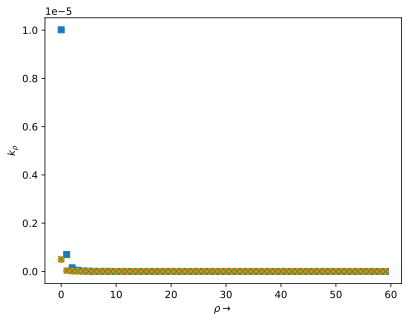

In [49]:
plt.plot(freq1[2::2],'s')
plt.plot(freq2[2::2],'o')
plt.plot(freq3[2:-1:2],'x')
print(max(freq1))
print(max(freq2))
print(max(freq3))
plt.ylabel(r'$k_\rho$')
plt.xlabel(r'$\rho\rightarrow$')

In [50]:
#qubit frequency for 01 transition (H1)
grq=Cq1*VZPF#relative coupling strength of qubit-readout mode
e01=flux_e[0]-flux_e[1]
omega_qr=charge_mat(0,1)*(grq**2)*(2*e01)/(e01**2-wr**2)
for l in range(2,Ncav):
    e0l=flux_e[0]-flux_e[l]
    e1l=flux_e[1]-flux_e[l]
    omega_qr=omega_qr+charge_mat(0,l)*(grq**2)/(e0l-wr)
    omega_qr=omega_qr-charge_mat(1,l)*(grq**2)/(e1l-wr)
def omega_q1(rho):
    x1=charge_mat(0,1)*((zpf_pp1[rho])**2)*(pq1[rho]**2)*(2*e01)/(e01**2-omega1[rho]**2)
    for l in range(2,Ncav):
        e0l=flux_e[0]-flux_e[l]
        e1l=flux_e[1]-flux_e[l]                                                        
        x1=x1+charge_mat(0,l)*((zpf_pp1[rho])**2)*(pq1[rho]**2)/(e0l-omega1[rho])
        x1=x1-charge_mat(1,l)*((zpf_pp1[rho])**2)*(pq1[rho]**2)/(e1l-omega1[rho])                                                
    return x1
omega_qubit=e01+omega_qr
omega_pq1=[0]
for i in range(1,N):
    omega_pq1.append(omega_q1(i))
    omega_qubit=omega_qubit+omega_pq1[-1]
print("H1")
print(omega_q1(2),omega_pq1[2])
print(omega_qubit)
print(omega_qr)


H1
0.0015939786471534476 0.0015939786471534476
-0.028315416755750385
1.3774836720649191e-05


In [51]:
#qubit frequency for 01 transition (H1)
grq=Cq2*VZPF#relative coupling strength of qubit-readout mode
e01=flux_e2[0]-flux_e2[1]
omega_qr2=charge_mat2(0,1)*(VZPF**2)*(grq**2)*(2*e01)/(e01**2-wr**2)
for l in range(2,Ncav):
    e0l=flux_e2[0]-flux_e2[l]
    e1l=flux_e2[1]-flux_e2[l]
    omega_qr2=omega_qr2+charge_mat2(0,l)*(grq**2)/(e0l-wr)
    omega_qr2=omega_qr2-charge_mat2(1,l)*(grq**2)/(e1l-wr)
def omega_q2(rho):
    x1=charge_mat2(0,1)*((zpf_pp2[rho])**2)*(pq2[rho]**2)*(2*e01)/(e01**2-omega2[rho]**2)
    for l in range(2,Ncav):
        e0l=flux_e2[0]-flux_e2[l]
        e1l=flux_e2[1]-flux_e2[l]                                                        
        x1=x1+charge_mat2(0,l)*((zpf_pp2[rho])**2)*(pq2[rho]**2)/(e0l-omega2[rho])
        x1=x1-charge_mat2(1,l)*((zpf_pp2[rho])**2)*(pq2[rho]**2)/(e1l-omega2[rho])                                                
    return x1
omega_qubit2=e01+omega_qr2
omega_pq2=[0]
for i in range(1,N):
    omega_pq2.append(omega_q2(i))
    omega_qubit2=omega_qubit2+omega_pq2[-1]
print("H2")
print(omega_q2(2))
print(omega_qubit2)
print(omega_qr2)


H2
0.003450332292282187
-0.056588745493900694
1.0316226200237081e-06


In [52]:
#qubit frequency for 01 transition (H1)
grq=Cq3*VZPF#relative coupling strength of qubit-readout mode
e01=flux_e3[0]-flux_e3[1]
omega_qr3=charge_mat3(0,1)*(grq**2)*(2*e01)/(e01**2-wr**2)
for l in range(2,Ncav):
    e0l=flux_e3[0]-flux_e3[l]
    e1l=flux_e3[1]-flux_e3[l]
    omega_qr3=omega_qr3+charge_mat3(0,l)*(grq**2)/(e0l-wr)
    omega_qr3=omega_qr3-charge_mat3(1,l)*(grq**2)/(e1l-wr)
def omega_q3(rho):
    x1=charge_mat3(0,1)*((zpf_pp3[rho])**2)*(pq3[rho]**2)*(2*e01)/(e01**2-omega3[rho]**2)
    for l in range(2,Ncav):
        e0l=flux_e3[0]-flux_e3[l]
        e1l=flux_e3[1]-flux_e3[l]                                                        
        x1=x1+charge_mat3(0,l)*((zpf_pp3[rho])**2)*(pq3[rho]**2)/(e0l-omega3[rho])
        x1=x1-charge_mat3(1,l)*((zpf_pp3[rho])**2)*(pq3[rho]**2)/(e1l-omega3[rho])                                                
    return x1
omega_qubit3=e01+omega_qr3
omega_pq3=[0]
for i in range(1,N):
    omega_pq3.append(omega_q3(i))
    omega_qubit3=omega_qubit3+omega_pq3[-1]
print("H3")
print(omega_q3(2))
print(omega_qubit3)
print(omega_qr3)

H3
0.004101024858002578
-0.06707060678790937
2.51774221232911e-06


Text(0.5, 0, '$\\rho/2\\rightarrow$')

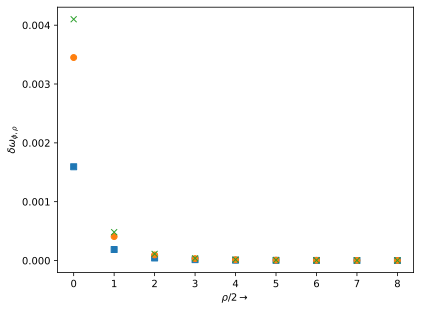

In [53]:
#the indices are sfifted by 1 because i=1 will be entered first at omega=0
plt.plot(omega_pq1[2:20:2],'s')
plt.plot(omega_pq2[2:20:2],'o')
plt.plot(omega_pq3[2:20:2],'x')
plt.ylabel(r'$\delta\omega_{\phi,\rho}$')
plt.xlabel(r'$\rho/2\rightarrow$')

In [58]:
#Dispersive shift for the qubit subspace
i=0
j=1
e01=flux_e[i]-flux_e[j]
chi_qr=charge_mat(i,j)*(VZPF**2)*(Cq1**2)*(2*e01)/(e01**2-wr**2)
for l in range(0,Ncav):
    if l!=i and l!=j:
        e0l=flux_e[i]-flux_e[l]
        e1l=flux_e[j]-flux_e[l]
        chi_qr=chi_qr+charge_mat(i,l)*(VZPF**2)*(Cq1**2)*e0l/(e0l**2-wr**2)
        chi_qr=chi_qr-charge_mat(j,l)*(VZPF**2)*(Cq1**2)*e1l/(e1l**2-wr**2)
def chi_q1(rho):
    x1=charge_mat(i,j)*((zpf_pp1[rho])**2)*(pq1[rho]**2)*(2*e01)/(e01**2-omega1[rho]**2)
    for l in range(0,Ncav):
        if l!=i and l!=j:
            e0l=flux_e[i]-flux_e[l]
            e1l=flux_e[j]-flux_e[l]                                                        
            x1=x1+charge_mat(i,l)*((zpf_pp1[rho])**2)*(pq1[rho]**2)*e0l/(e0l**2-omega1[rho]**2)
            x1=x1-charge_mat(j,l)*((zpf_pp1[rho])**2)*(pq1[rho]**2)*e1l/(e1l**2-omega1[rho]**2)                                                
    return x1
chi_pq1=[0]
for k in range(1,N):
    chi_pq1.append(chi_q1(k))
print("H1")
print(chi_qr)
np.savez('dispersive_shift.npz', chi_pq=chi_pq1)
print(chi_q1(2),chi_pq1[2])#-0.02 for Catelani at zero flux

H1
0.0001913923039980679
-0.004555055710197799 -0.004555055710197799


In [55]:
#Dispersive shift for the qubit subspace
grq=Cq2#relative coupling strength of qubit-readout mode
e01=flux_e2[0]-flux_e2[1]
chi_qr2=charge_mat2(0,1)*(VZPF**2)*(Cq2**2)*(2*e01)/(e01**2-wr**2)
for l in range(2,Ncav):
    e0l=flux_e2[0]-flux_e2[l]
    e1l=flux_e2[1]-flux_e2[l]
    chi_qr2=chi_qr2+charge_mat2(0,l)*(VZPF**2)*(Cq2**2)*e0l/(e0l**2-wr**2)
    chi_qr2=chi_qr2-charge_mat2(1,l)*(VZPF**2)*(Cq2**2)*e1l/(e1l**2-wr**2)
def chi_q2(rho):
    x1=charge_mat2(0,1)*((zpf_pp2[rho])**2)*(pq2[rho]**2)*(2*e01)/(e01**2-omega2[rho]**2)
    for l in range(2,Ncav):
        e0l=flux_e2[0]-flux_e2[l]
        e1l=flux_e2[1]-flux_e2[l]                                                        
        x1=x1+charge_mat2(0,l)*((zpf_pp2[rho])**2)*(pq2[rho]**2)*e0l/(e0l**2-omega2[rho]**2)
        x1=x1-charge_mat2(1,l)*((zpf_pp2[rho])**2)*(pq2[rho]**2)*e1l/(e1l**2-omega2[rho]**2)                                                
    return x1
chi_pq2=[0]
for i in range(1,N):
    chi_pq2.append(chi_q2(i))
print("H2")
print(chi_qr2)
print(chi_pq2[2],chi_q2(2))

H2
2.2192471966660978e-05
-0.02220160069765621 -0.02220160069765621


In [56]:
#Dispersive shift for the qubit subspace
e01=flux_e3[0]-flux_e3[1]
chi_qr3=charge_mat3(0,1)*(VZPF**2)*(Cq3**2)*(2*e01)/(e01**2-wr**2)
for l in range(2,Ncav):
    e0l=flux_e3[0]-flux_e3[l]
    e1l=flux_e3[1]-flux_e3[l]
    chi_qr3=chi_qr3+charge_mat3(0,l)*(VZPF**2)*(Cq3**2)*e0l/(e0l**2-wr**2)
    chi_qr3=chi_qr3-charge_mat3(1,l)*(VZPF**2)*(Cq3**2)*e1l/(e1l**2-wr**2)
def chi_q3(rho):
    x1=charge_mat3(0,1)*((zpf_pp3[rho])**2)*(pq3[rho]**2)*(2*e01)/(e01**2-omega3[rho]**2)
    for l in range(2,Ncav):
        e0l=flux_e3[0]-flux_e3[l]
        e1l=flux_e3[1]-flux_e3[l]                                                        
        x1=x1+charge_mat3(0,l)*((zpf_pp3[rho])**2)*(pq3[rho]**2)*e0l/(e0l**2-omega3[rho]**2)
        x1=x1-charge_mat3(1,l)*((zpf_pp3[rho])**2)*(pq3[rho]**2)*e1l/(e1l**2-omega3[rho]**2)                                                
    return x1
chi_pq3=[0]
for i in range(1,N):
    chi_pq3.append(chi_q3(i))
print("H3")
print(chi_qr3)
print(chi_pq3[2],chi_q3(2))

H3
6.61512834185233e-05
-0.03806671093650535 -0.03806671093650535


Text(0.5, 0, '$\\rho/2\\rightarrow$')

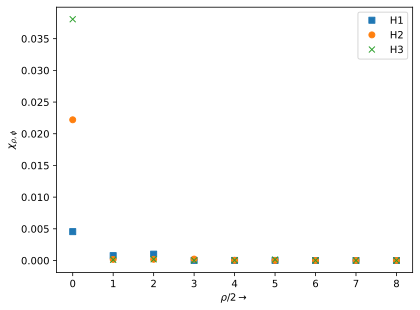

In [57]:
plt.plot(np.abs(chi_pq1[2:20:2]),'s',label='H1')
plt.plot(np.abs(chi_pq2[2:20:2]),'o',label='H2')
plt.plot(np.abs(chi_pq3[2:20:2]),'x',label='H3')
plt.legend()
plt.ylabel(r'$\chi_{\rho,\phi}$')
plt.xlabel(r'$\rho/2\rightarrow$')

5.618287730478615e-09
9.780871457766848e-12


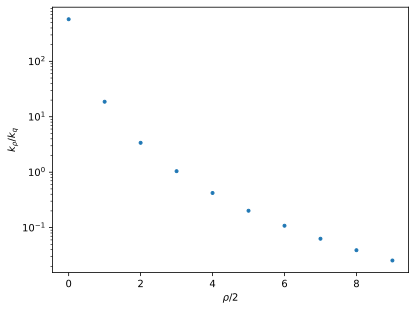

In [97]:
#Purcell decay rate.
g_qub=VZPF*Cq1
pur_qub=kr*(g_qub**2)*charge_mat(0,1)/((-omega_qubit-wr)**2)
def pur1(rho):
    g_rho=VZPF*Cp1[rho]*zpf_pp1[rho]#remember that this quantity is half of what catelani has so there will be that error.
    return kr*(g_rho**2)/((omega1[rho]-wr)**2)
pur_rho=[0]
comp=[]
for i in range(1,N):
    pur_rho.append(pur1(i))
    comp.append(pur_rho[-1]/pur_qub)
plt.plot(comp[1:20:2],'.')
plt.yscale('log')
plt.ylabel(r'$k_\rho/k_q$')
plt.xlabel(r'$\rho/2$')
print(pur_rho[2])
print(pur_qub)

In [100]:
#qubit Dephasing non-driven resonator
Ncav=10
rho=2
g=basis(2,0)
e=basis(2,1)
px=(g+e).unit()
a=destroy(Ncav)
ad=a.dag()
nOp=ad*a
Ham=(chi_pq1[rho]*(10**3))*tensor(sigmaz(),nOp)#dispersive hamiltonian (chi is also in MHz)
dephase=[]
for Q in np.geomspace(1000,1000000,100):
    k=(omega1[rho]/Q)*(10**3)
    decay=np.sqrt(k)*tensor(qeye(2),a)#decay operator
    q_out=[]
    for nr in np.geomspace(0.0000001,2,100):
        state=tensor(ket2dm(px),thermal_dm(Ncav,nr))
        state=mesolve(Ham,state,tlist=[0,10/k],c_ops=decay,options=Options(nsteps=1000000)).states[-1].ptrace(0).unit()
        q_out.append(1-(state*ket2dm(px)).tr())
    dephase.append(q_out)
np.save("dephasing_th.npy",dephase)

122 193.7022932465912


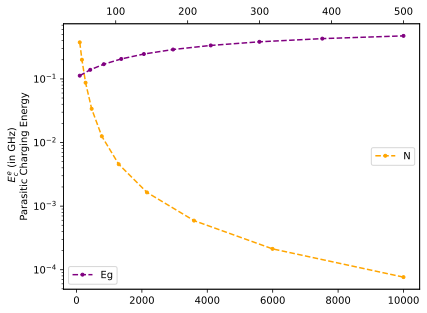

In [77]:
#Nn and Eg dependence on 
def Chargep(Count,ground):
    return (1/ECJ+1/(4*ground*s(2,Count)**2))**(-1)
Count=np.geomspace(100,10000,10)
Ground=np.geomspace(50,500,10)
ChargepN=[Chargep(i,Eg) for i in Count]
print(N,Eg)
ChargepG=[Chargep(N,i) for i in Ground]
np.save("qubit-energy-G.npy",ChargeG)
np.save("parasitic-energy-G.npy",ChargepG)
fig, ax1 = plt.subplots()
ax1.plot(Count,ChargepN,'.--',color='orange',label='N')
ax1.legend(loc='center right')
ax2 = ax1.twiny()
ax2.plot(Ground,ChargepG,'.--',color='purple',label='Eg')
ax2.legend(loc='lower left')
ax2.set_yscale('log')
ax1.set_ylabel(r" $E_c^e$ (in GHz)"+"\n"+"Parasitic Charging Energy")
#fig.tight_layout()
plt.savefig('Parasitic-Charging-Energy.pdf', format="pdf")
plt.show()
plt.close(fig)

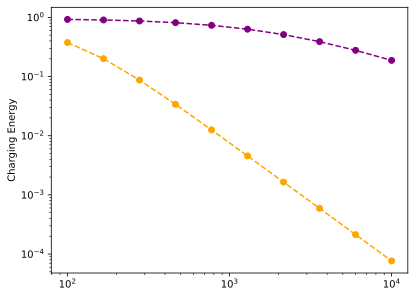

In [78]:
#N and Eg dependence for H1 only
def Charge(Count,ground):
    Et1=((Count-1)/ground+2/Eg1+2/Ec)**(-1)
    G1=(1/64/Et1)*(1-(2/3)*(Count**2-1)/Count*(Et1/ground))
    M1=1/16*(1/EC1+1/Count/ECJ)
    Charge1=1/16/(G1+M1)
    return Charge1

Count=np.geomspace(100,10000,10)
Ground=np.geomspace(50,500,10)
ChargeN=[Charge(i,Eg) for i in Count]
ChargeG=[Charge(N,i) for i in Ground]
fig, ax1 = plt.subplots()
ax1.plot(Count,ChargepN,'--o',color='orange',label='N')
ax1.plot(Count,ChargeN,'--o',color='purple',label='N')
#ax1.plot(Ground,ChargepG,'--o',color='orange',label=r"Qubit: $\tilde{E}_c^\phi$ [in GHz]")
ax1.set_yscale('log')
ax1.set_xscale('log')
#ax1.plot(Ground,ChargeG,'--o',color='purple',label='Parasitic Mode: $E^e_{c,\mu=2}$ [in GHz]')
ax1.set_ylabel("Charging Energy")
#fig.tight_layout()
#ax1.legend(loc='center left')
np.save("qubit-energy-N.npy",ChargeN)
np.save("parasitic-energy-N.npy",ChargepN)
#plt.savefig('Charging-Energy.pdf', format="pdf")
plt.show()
plt.close(fig)

122 193.7022932465912


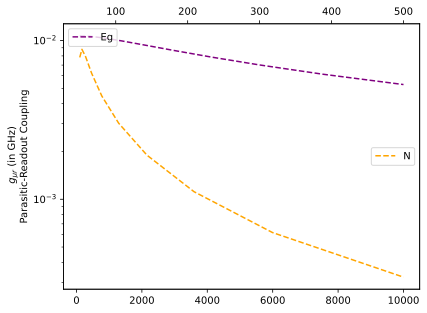

In [84]:
#only for mu=2 and H1
def couplingp(Count,ground):
    return 4*VZPF*zpf_pp1[2]*Charge(Count,ground)*Chargep(Count,ground)*c(2,Count)/4/np.sqrt(2*Count)/ground/Ec/s(2,Count)**2
Count=np.geomspace(100,10000,10)
Ground=np.geomspace(50,500,10)
CouplingpN=[couplingp(i,Eg) for i in Count]
print(N,Eg)
CouplingpG=[couplingp(N,i) for i in Ground]
np.save("couplingpN.npy",CouplingpN)
np.save("couplingpG.npy",CouplingpG)
fig, ax1 = plt.subplots()
ax1.plot(Count,CouplingpN,'--',color='orange',label='N')
ax1.legend(loc='center right')
ax2 = ax1.twiny()
#ax1.set_xscale('log')
ax2.set_yscale('log')
ax2.plot(Ground,CouplingpG,'--',color='purple',label='Eg')
ax2.legend(loc='upper left')
ax1.set_ylabel(r" $g_{\mu r}$ (in GHz)"+"\n"+"Parasitic-Readout Coupling")
#fig.tight_layout()
plt.savefig('Parasitic-Readout.pdf', format="pdf")
plt.show()
plt.close(fig)

122 193.7022932465912


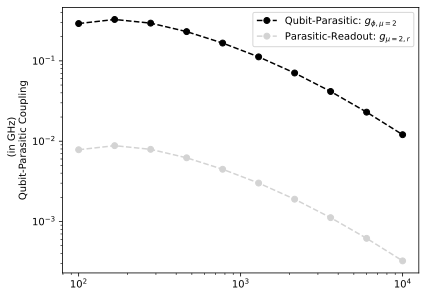

In [85]:
def couplingpq(Count,ground):
    return 2*zpf_p1*zpf_pp1[2]*np.sqrt(2/Count)*Charge(Count,ground)*Chargep(Count,ground)*c(2,Count)/ground/s(2,Count)**2
Count=np.geomspace(100,10000,10)
Ground=np.geomspace(50,500,10)
CouplingpqN=[couplingpq(i,Eg) for i in Count]
print(N,Eg)
CouplingpqG=[couplingpq(N,i) for i in Ground]
np.save("couplingpqN.npy",CouplingpqN)
np.save("couplingpqG.npy",CouplingpqG)
fig, ax1 = plt.subplots()
ax1.plot(Count,CouplingpqN,'--o',color='black',label=r"Qubit-Parasitic: $g_{\phi,\mu=2}$")
ax1.plot(Count,CouplingpN,'--o',color='lightgrey',label=r"Parasitic-Readout: $g_{\mu=2,r}$")
#ax1.legend(loc='center right')
#ax2 = ax1.twiny()
#ax1.plot(Ground,CouplingpqG,'--o',color='black',label=r"Qubit-Parasitic: $g_{\phi,\mu=2}$")
#ax1.plot(Ground,CouplingpG,'--o',color='lightgrey',label=r"Parasitic-Readout: $g_{\mu=2,r}$")
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.legend(loc='center left')
ax1.set_ylabel(r"  (in GHz)"+"\n"+"Qubit-Parasitic Coupling")
#fig.tight_layout()
plt.savefig('Parasitic-Qubit.pdf', format="pdf")
plt.legend()
plt.show()
plt.close(fig)

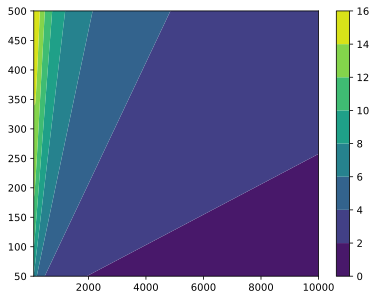

In [86]:
#Nn and Eg dependence on 
def Freqp(Count,ground):
    E1=(1/ECJ+1/(4*ground*s(2,Count)**2))**(-1)
    E_JJ=(60*tpi/122)*Count
    return np.sqrt(8*E1*E_JJ)
Count=np.geomspace(100,10000,100)
Ground=np.linspace(50,500,100)
Freq_p=[[Freqp(i,j) for i in Count] for j in Ground]
fig, ax1 = plt.subplots()
a=ax1.contourf(Count,Ground,Freq_p,cmap="viridis")
cbar=plt.colorbar(a, ax=ax1)
np.save("freq.npy",Freq_p)